<a href="https://colab.research.google.com/github/Tessa18/Weather_Trend_Prediction/blob/main/Weather_trend_spark_sql.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INSTALLING SPARK

In [1]:
!pip install pyspark

In [2]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -qO spark.tgz "https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz"
!tar -xzf spark.tgz

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("WeatherForecasting").getOrCreate()
spark

IMPORTING DATASET

In [5]:
df = spark.read.csv("GlobalWeatherRepository.csv", header=True, inferSchema=True)
df.show(5)

+-----------+----------------+--------+---------+--------------+------------------+-------------------+-------------------+----------------------+--------------+--------+--------+-----------+--------------+-----------+-----------+---------+---------+--------+-----+------------------+---------------------+-------------+----------------+--------+--------+--------+---------------------------+-----------------+----------------------------+---------------------------+-----------------+----------------+------------------------+--------------------------+--------+--------+--------+--------+--------------+-----------------+
|    country|   location_name|latitude|longitude|      timezone|last_updated_epoch|       last_updated|temperature_celsius|temperature_fahrenheit|condition_text|wind_mph|wind_kph|wind_degree|wind_direction|pressure_mb|pressure_in|precip_mm|precip_in|humidity|cloud|feels_like_celsius|feels_like_fahrenheit|visibility_km|visibility_miles|uv_index|gust_mph|gust_kph|air_quality_

REGISTER DATA AS A SQL TABLE

In [6]:
df.createOrReplaceTempView("weather_data")

SQL QUERIES

In [7]:
spark.sql("""
    SELECT location_name, country, temperature_celsius
    FROM weather_data
    ORDER BY temperature_celsius DESC
    LIMIT 5
""").show()

+-------------+-------+-------------------+
|location_name|country|temperature_celsius|
+-------------+-------+-------------------+
|  Kuwait City| Kuwait|               49.2|
|      Baghdad|   Iraq|               49.1|
|      Baghdad|   Iraq|               49.1|
|  Kuwait City| Kuwait|               48.9|
|      Baghdad|   Iraq|               48.8|
+-------------+-------+-------------------+



In [8]:
spark.sql("""
    SELECT country, AVG(temperature_celsius) AS avg_temp
    FROM weather_data
    GROUP BY country
    ORDER BY avg_temp DESC
""").show()

+--------------------+------------------+
|             country|          avg_temp|
+--------------------+------------------+
|       Saudi Arabien|              45.0|
|            Marrocos|              40.3|
|        Turkménistan|              37.8|
|        Saudi Arabia| 35.42236286919832|
|              Kuwait| 34.98828451882846|
|               Qatar|  34.5903361344538|
|                Iraq| 34.52719665271966|
|              Турция|              34.0|
|United Arab Emirates| 33.48535564853557|
|            Djibouti| 33.42911392405063|
|               Sudan|  32.3090336134454|
|                Oman|32.182426778242686|
|             Bahrain| 32.15313807531381|
|               Niger| 31.66344537815126|
|               India| 31.64388185654009|
|                Chad| 31.57364016736401|
|                Inde|              31.2|
|Central African R...| 31.03571428571427|
|        Burkina Faso|30.474789915966387|
|               Egypt| 30.25840336134454|
+--------------------+------------

In [9]:
spark.sql("""
    SELECT country, location_name, `air_quality_PM2.5`
    FROM weather_data
    WHERE `air_quality_PM2.5` > 100
    ORDER BY `air_quality_PM2.5` DESC
""").show()

+---------+-------------+-----------------+
|  country|location_name|air_quality_PM2.5|
+---------+-------------+-----------------+
|    Chile|     Santiago|           1614.1|
|    Chile|     Santiago|           1406.3|
|    Chile|     Santiago|           1204.9|
|    Chile|     Santiago|           1190.5|
|    Chile|     Santiago|           1188.4|
|    Chile|     Santiago|           1119.7|
|    Chile|     Santiago|           1116.0|
|    Chile|     Santiago|           1078.5|
|    Chile|     Santiago|           1018.7|
|    Chile|     Santiago|           1012.9|
|    Chile|     Santiago|            989.0|
|    Chile|     Santiago|            983.8|
|    Chile|     Santiago|            981.8|
|    Chile|     Santiago|            976.3|
|    Chile|     Santiago|            941.0|
|    Chile|     Santiago|            939.8|
|    Chile|     Santiago|            930.5|
|    Chile|     Santiago|            920.8|
|    Chile|     Santiago|            916.4|
|Indonesia|      Jakarta|       

FORECASTING TRENDS

In [10]:
from pyspark.sql.functions import to_date

df = df.withColumn("date", to_date(df["last_updated"]))
df.createOrReplaceTempView("weather_data")

In [11]:
spark.sql("""
    SELECT date, AVG(temperature_celsius) AS avg_temp
    FROM weather_data
    GROUP BY date
    ORDER BY date
""").show()

+----------+------------------+
|      date|          avg_temp|
+----------+------------------+
|2024-05-16|23.767195767195766|
|2024-05-17|24.451648351648352|
|2024-05-18|25.355609756097564|
|2024-05-19|25.270103092783504|
|2024-05-20| 25.43076923076923|
|2024-05-21| 25.38307692307692|
|2024-05-22|25.123076923076912|
|2024-05-23|25.066153846153846|
|2024-05-24| 25.08871794871794|
|2024-05-25|25.249743589743588|
|2024-05-26| 25.25435897435898|
|2024-05-27|25.660512820512825|
|2024-05-28| 25.50051282051283|
|2024-05-29|25.575384615384614|
|2024-05-30|25.672820512820508|
|2024-05-31|25.849484536082475|
|2024-06-01| 26.16102564102565|
|2024-06-02|25.891282051282037|
|2024-06-03|26.124102564102568|
|2024-06-04|26.258974358974363|
+----------+------------------+
only showing top 20 rows



In [12]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Select features and label
feature_cols = ["humidity", "wind_kph", "pressure_mb"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

df_ml = assembler.transform(df).select("features", "temperature_celsius")

In [13]:
# Split the dataset
train_df, test_df = df_ml.randomSplit([0.8, 0.2], seed=42)

# Initialize the model
lr = LinearRegression(featuresCol="features", labelCol="temperature_celsius")

# Train the model
model = lr.fit(train_df)

# Make predictions
predictions = model.transform(test_df)
predictions.select("features", "temperature_celsius", "prediction").show(10)

+-----------------+-------------------+------------------+
|         features|temperature_celsius|        prediction|
+-----------------+-------------------+------------------+
|[3.0,13.3,1016.0]|               22.6| 30.10642824830893|
|[3.0,25.9,1003.0]|               44.1|37.991687086475395|
| [4.0,6.8,1002.0]|               45.0| 38.58514687196771|
|[4.0,11.5,1015.0]|               28.2| 30.59278198467598|
|[4.0,15.5,1013.0]|               31.2|31.793135535961028|
| [4.0,22.0,993.0]|               48.9|44.004072935845784|
|[4.0,31.0,1001.0]|               45.4| 39.04788120306796|
| [5.0,6.8,1006.0]|               44.2| 35.99756173707715|
|[5.0,11.2,1010.0]|               36.1|33.520084980798856|
|[5.0,11.2,1011.0]|               40.0| 32.90752600294536|
+-----------------+-------------------+------------------+
only showing top 10 rows



In [14]:
spark.sql("CACHE TABLE weather_data")

DataFrame[]

In [15]:
spark.sql("SHOW TABLE EXTENDED LIKE 'weather_data'").show(truncate=False)

+---------+------------+-----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [16]:
spark.sql("""
    SELECT location_name, country, temperature_celsius
    FROM weather_data
    ORDER BY temperature_celsius DESC
    LIMIT 5
""").show()

+-------------+-------+-------------------+
|location_name|country|temperature_celsius|
+-------------+-------+-------------------+
|  Kuwait City| Kuwait|               49.2|
|      Baghdad|   Iraq|               49.1|
|      Baghdad|   Iraq|               49.1|
|  Kuwait City| Kuwait|               48.9|
|      Baghdad|   Iraq|               48.8|
+-------------+-------+-------------------+



In [17]:
spark.sql("""
    SELECT location_name, country, temperature_celsius
    FROM weather_data
    ORDER BY temperature_celsius ASC
    LIMIT 5
""").show()

+-------------+--------+-------------------+
|location_name| country|temperature_celsius|
+-------------+--------+-------------------+
|  Ulaanbaatar|Mongolia|              -24.8|
|  Ulaanbaatar|Mongolia|              -24.2|
|  Ulaanbaatar|Mongolia|              -23.4|
|  Ulaanbaatar|Mongolia|              -23.4|
|  Ulaanbaatar|Mongolia|              -22.9|
+-------------+--------+-------------------+



In [18]:
spark.sql("""
    SELECT to_date(last_updated) AS date,
           AVG(temperature_celsius) AS avg_temp
    FROM weather_data
    GROUP BY to_date(last_updated)
    ORDER BY date
""").show()

+----------+------------------+
|      date|          avg_temp|
+----------+------------------+
|2024-05-16|23.767195767195766|
|2024-05-17|24.451648351648352|
|2024-05-18|25.355609756097564|
|2024-05-19|25.270103092783504|
|2024-05-20| 25.43076923076923|
|2024-05-21| 25.38307692307692|
|2024-05-22|25.123076923076912|
|2024-05-23|25.066153846153846|
|2024-05-24| 25.08871794871794|
|2024-05-25|25.249743589743588|
|2024-05-26| 25.25435897435898|
|2024-05-27|25.660512820512825|
|2024-05-28| 25.50051282051283|
|2024-05-29|25.575384615384614|
|2024-05-30|25.672820512820508|
|2024-05-31|25.849484536082475|
|2024-06-01| 26.16102564102565|
|2024-06-02|25.891282051282037|
|2024-06-03|26.124102564102568|
|2024-06-04|26.258974358974363|
+----------+------------------+
only showing top 20 rows



In [19]:
spark.sql("""
    SELECT country,
           MIN(temperature_celsius) AS min_temp,
           MAX(temperature_celsius) AS max_temp
    FROM weather_data
    GROUP BY country
    ORDER BY max_temp DESC
""").show()

+--------------------+--------+--------+
|             country|min_temp|max_temp|
+--------------------+--------+--------+
|              Kuwait|    15.1|    49.2|
|                Iraq|    12.1|    49.1|
|            Djibouti|    25.1|    47.1|
|        Saudi Arabia|    13.2|    46.3|
|               Qatar|    18.5|    46.2|
|                Chad|    23.1|    45.0|
|       Saudi Arabien|    45.0|    45.0|
|               India|    14.3|    44.8|
|               Sudan|    20.5|    44.2|
|United Arab Emirates|    20.4|    44.1|
|             Bahrain|    16.2|    43.3|
|               Niger|    22.6|    43.0|
|        Turkmenistan|     3.0|    42.5|
|               Egypt|    15.1|    42.4|
|               Syria|     6.9|    42.3|
|          Uzbekistan|    -3.6|    42.3|
|                Oman|    21.0|    42.0|
|                Mali|    20.2|    42.0|
|            Pakistan|    15.4|    41.6|
|        Burkina Faso|    22.8|    41.5|
+--------------------+--------+--------+
only showing top

In [20]:
spark.sql("""
    SELECT country, location_name, `air_quality_PM2.5`
    FROM weather_data
    WHERE `air_quality_PM2.5` > 100
    ORDER BY `air_quality_PM2.5` DESC
""").show()

+---------+-------------+-----------------+
|  country|location_name|air_quality_PM2.5|
+---------+-------------+-----------------+
|    Chile|     Santiago|           1614.1|
|    Chile|     Santiago|           1406.3|
|    Chile|     Santiago|           1204.9|
|    Chile|     Santiago|           1190.5|
|    Chile|     Santiago|           1188.4|
|    Chile|     Santiago|           1119.7|
|    Chile|     Santiago|           1116.0|
|    Chile|     Santiago|           1078.5|
|    Chile|     Santiago|           1018.7|
|    Chile|     Santiago|           1012.9|
|    Chile|     Santiago|            989.0|
|    Chile|     Santiago|            983.8|
|    Chile|     Santiago|            981.8|
|    Chile|     Santiago|            976.3|
|    Chile|     Santiago|            941.0|
|    Chile|     Santiago|            939.8|
|    Chile|     Santiago|            930.5|
|    Chile|     Santiago|            920.8|
|    Chile|     Santiago|            916.4|
|Indonesia|      Jakarta|       

In [21]:
from pyspark.ml.feature import VectorAssembler

# Select important features
feature_cols = ["humidity", "wind_kph", "pressure_mb"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

df_ml = assembler.transform(df).select("features", "temperature_celsius")

In [22]:
train_df, test_df = df_ml.randomSplit([0.8, 0.2], seed=42)

In [23]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="temperature_celsius")
model = lr.fit(train_df)

In [24]:
predictions = model.transform(test_df)
predictions.select("features", "temperature_celsius", "prediction").show(10)

+-----------------+-------------------+------------------+
|         features|temperature_celsius|        prediction|
+-----------------+-------------------+------------------+
|[3.0,13.3,1016.0]|               22.6| 30.10642824830893|
|[3.0,25.9,1003.0]|               44.1|37.991687086475395|
| [4.0,6.8,1002.0]|               45.0| 38.58514687196771|
|[4.0,11.5,1015.0]|               28.2| 30.59278198467598|
|[4.0,15.5,1013.0]|               31.2|31.793135535961028|
| [4.0,22.0,993.0]|               48.9|44.004072935845784|
|[4.0,31.0,1001.0]|               45.4| 39.04788120306796|
| [5.0,6.8,1006.0]|               44.2| 35.99756173707715|
|[5.0,11.2,1010.0]|               36.1|33.520084980798856|
|[5.0,11.2,1011.0]|               40.0| 32.90752600294536|
+-----------------+-------------------+------------------+
only showing top 10 rows



In [25]:
!pip install matplotlib seaborn

PLOT THE DATA

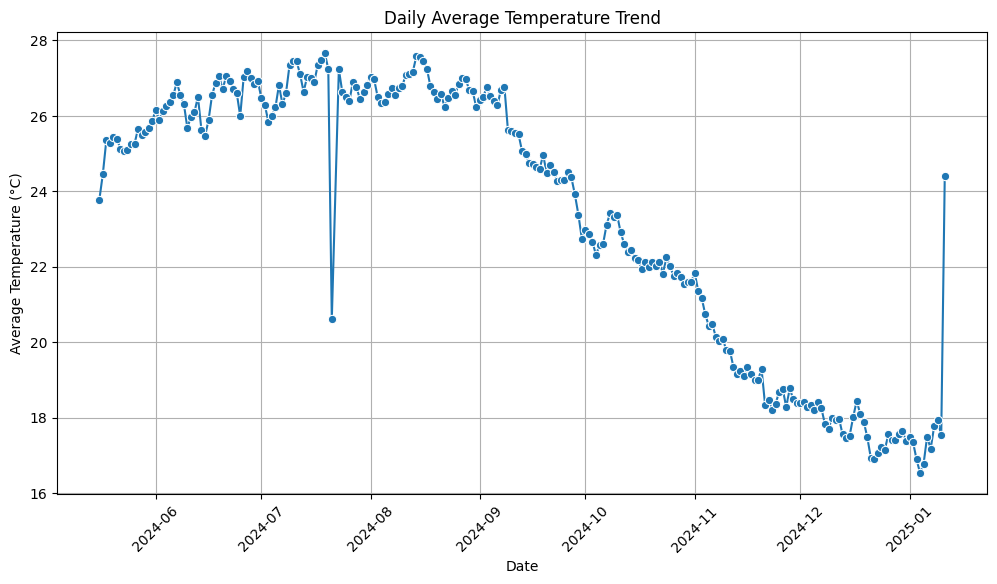

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Run the SQL to get the daily average temperature
daily_temp_df = spark.sql("""
    SELECT to_date(last_updated) AS date,
           AVG(temperature_celsius) AS avg_temp
    FROM weather_data
    GROUP BY to_date(last_updated)
    ORDER BY date
""").toPandas()  # Convert to Pandas DataFrame for plotting

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_temp_df, x='date', y='avg_temp', marker='o')
plt.title("Daily Average Temperature Trend")
plt.xlabel("Date")
plt.ylabel("Average Temperature (°C)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [28]:
!pip install statsmodels

ARIMA

In [30]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Get the daily average temperature data (converted to Pandas DataFrame)
daily_temp_df = spark.sql("""
    SELECT to_date(last_updated) AS date,
           AVG(temperature_celsius) AS avg_temp
    FROM weather_data
    GROUP BY to_date(last_updated)
    ORDER BY date
""").toPandas()  # Convert to Pandas DataFrame for visualization

# Fit ARIMA model (order = (p, d, q))
# Adjust (p, d, q) based on your data's characteristics
model = ARIMA(daily_temp_df['avg_temp'], order=(5, 1, 0))
model_fit = model.fit()

# Make a prediction for the next 10 days
forecast = model_fit.forecast(steps=10)
print(forecast)

240    20.685097
241    20.843106
242    20.953305
243    20.873434
244    21.211264
245    20.966770
246    21.011504
247    21.019475
248    21.010713
249    21.028525
Name: predicted_mean, dtype: float64


In [31]:
!pip install tensorflow

LSTM

In [33]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Prepare data for LSTM model
daily_temp_df = spark.sql("""
    SELECT to_date(last_updated) AS date,
           AVG(temperature_celsius) AS avg_temp
    FROM weather_data
    GROUP BY to_date(last_updated)
    ORDER BY date
""").toPandas()  # Convert to Pandas DataFrame for plotting

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(daily_temp_df['avg_temp'].values.reshape(-1, 1))

# Prepare dataset for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 10
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data into training and testing
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions
predictions = scaler.inverse_transform(predictions)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.4011
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0625 
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0541
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0110
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0205
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0125
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0114
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0084
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0087
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0073
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


ANALYZE WEATHER TRENDS AND SPOT PATTERNS

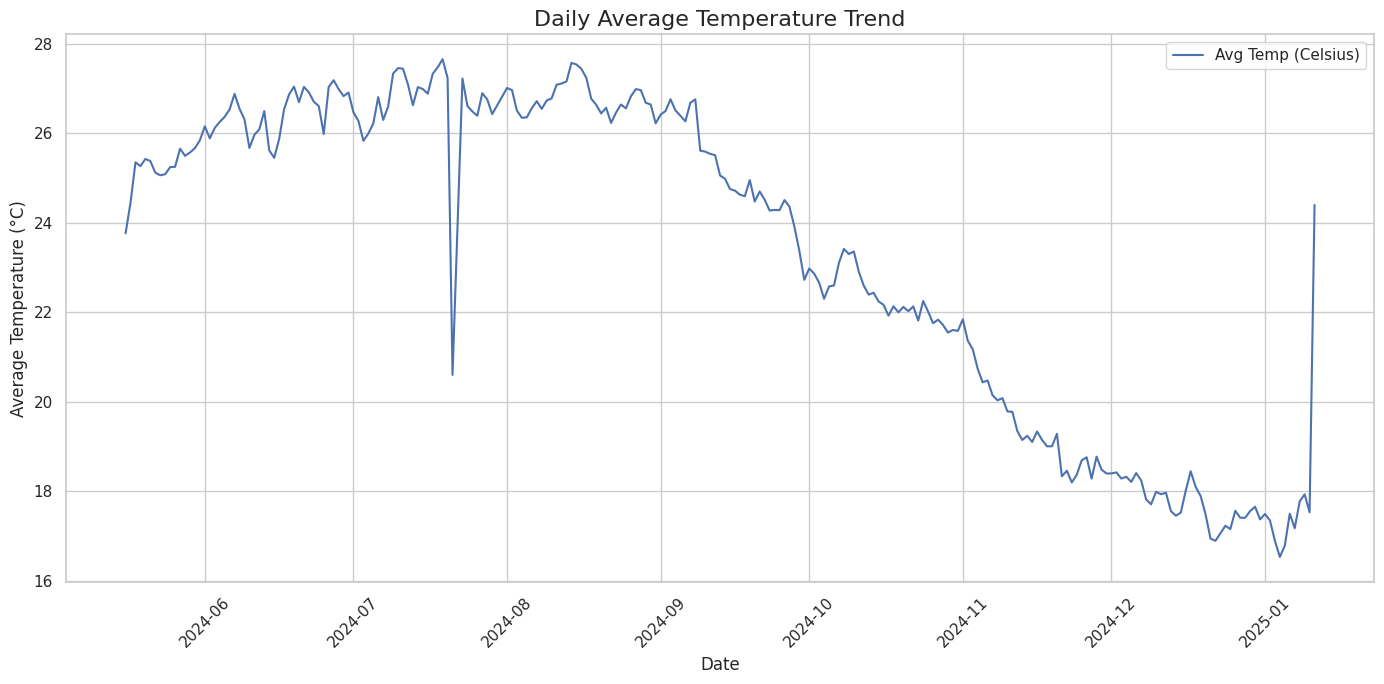

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
sns.set(style="whitegrid")

# Plot the temperature trend over time
plt.figure(figsize=(14, 7))
plt.plot(daily_temp_df['date'], daily_temp_df['avg_temp'], color='b', label='Avg Temp (Celsius)')
plt.title('Daily Average Temperature Trend', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Temperature (°C)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

ARIMA MODEL

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

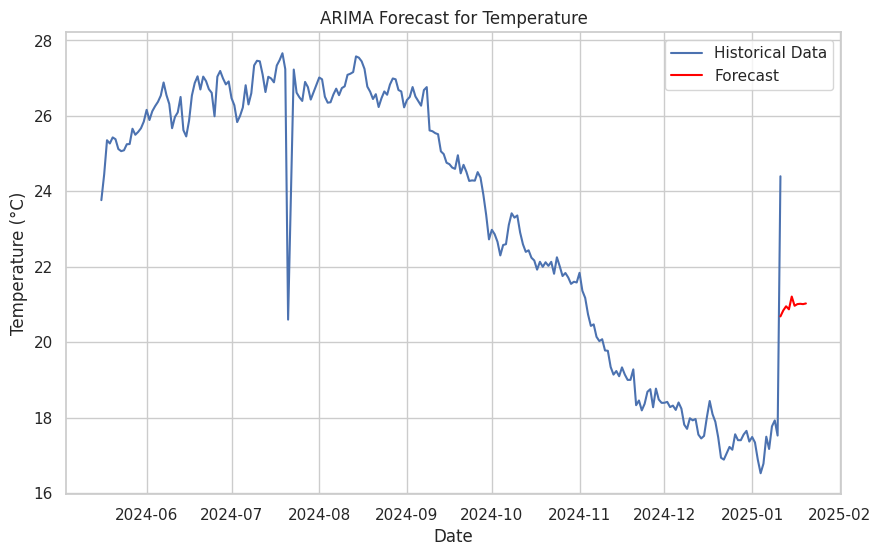

In [36]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# Assume `daily_temp_df` has already been loaded with temperature data
# Convert the `date` column to a datetime format
daily_temp_df['date'] = pd.to_datetime(daily_temp_df['date'])
daily_temp_df.set_index('date', inplace=True)

# Fit an ARIMA model
model = ARIMA(daily_temp_df['avg_temp'], order=(5,1,0))  # Example parameters (p, d, q)
model_fit = model.fit()

# Make a forecast for the next 10 days
forecast = model_fit.forecast(steps=10)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(daily_temp_df.index, daily_temp_df['avg_temp'], label='Historical Data')
plt.plot(pd.date_range(daily_temp_df.index[-1], periods=10, freq='D'), forecast, color='red', label='Forecast')
plt.title('ARIMA Forecast for Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

LSTM MODEL

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2186
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0385
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0290
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0122
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0161
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0108
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0108
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0059
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0058
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0049
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0044
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0076
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0072
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0046
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0062
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/

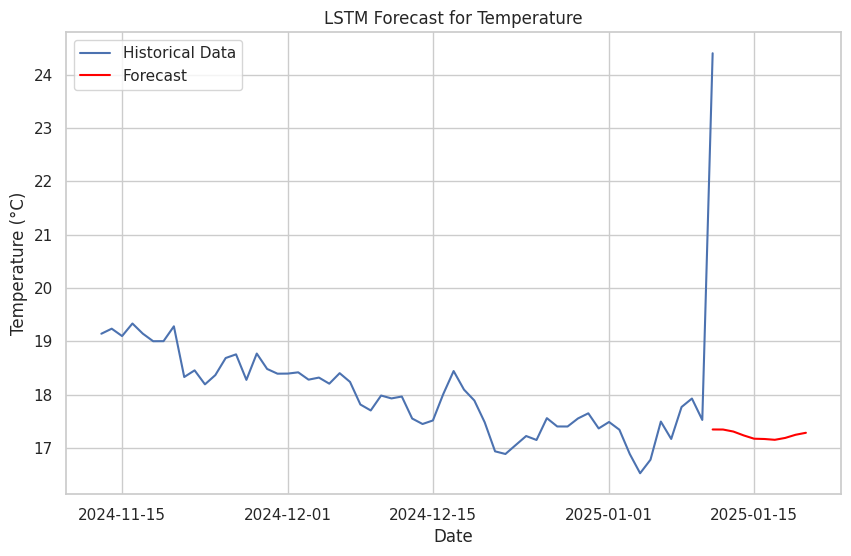

In [37]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Prepare the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(daily_temp_df['avg_temp'].values.reshape(-1, 1))

# Create sequences for LSTM input (timesteps)
timesteps = 60  # Use the last 60 days to predict the next day's temperature
X, y = [], []
for i in range(timesteps, len(scaled_data)):
    X.append(scaled_data[i-timesteps:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape X for LSTM [samples, timesteps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define and train the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=20, batch_size=32)

# Forecast the next 10 days
predictions = model.predict(X[-10:])

# Inverse transform the predictions to original scale
predictions = scaler.inverse_transform(predictions)

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(daily_temp_df.index[-60:], daily_temp_df['avg_temp'].values[-60:], label='Historical Data')
plt.plot(pd.date_range(daily_temp_df.index[-1], periods=10, freq='D'), predictions, color='red', label='Forecast')
plt.title('LSTM Forecast for Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()